In [1]:
import warnings
warnings.filterwarnings("ignore")
import pyart
import numpy as np
from pyart.retrieve import get_freq_band
from matplotlib import pyplot as plt
import glob, os
import time
from pymeso import llsd
import scipy


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [2]:
def _drop_fields(radar):
    fields_to_drop = ["DBMHC", "DBMVC", "VS", "VS_F", "VL", "VL_F", "DBZHCC"]
    for field in fields_to_drop:
        if field in radar.fields:
            del radar.fields[field]
    return radar


def _align_field(field):
    values, counts = np.unique(field['data'], return_counts=True)
    c_value = values[np.argmax(counts)]
    field['data'] = np.array([c_value])
    return field


def align_radar_coords(radar):
    for field_name in ['longitude', 'latitude', 'altitude', 'altitude_agl']:
        setattr(radar, field_name, _align_field(getattr(radar, field_name)))
    return radar


def mask_data(radar, field, gatefilter):
    dsp=pyart.correct.despeckle_field(radar, field, gatefilter=gatefilter, size= 15)
    new_field = radar.fields[field].copy()
    new_field['data'] = np.ma.masked_where(dsp.gate_included == False, radar.fields[field]['data'])
    radar.add_field(field, new_field, replace_existing=True)
    return radar


#function to dealiase the Doppler velocity
def dealiase(radar, vel_name='VEL_F', gatefilter=None, method="unwrap"):
    '''
    Dealias Doppler velocities using Py-ART.
    method : str
        Method to use for the dealiasing. Can be 'unwrap' or 'region'.
    '''
    # Create a GateFilter if one was not provided
    if gatefilter is None:
        gatefilter = pyart.correct.GateFilter(radar)
    # Dealias Doppler velocities using the selected method
    if method == "unwrap":
        corr_vel = pyart.correct.dealias_unwrap_phase(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    elif method == "region":
        corr_vel = pyart.correct.dealias_region_based(radar, vel_field=vel_name,
                                                      keep_original=False, gatefilter=gatefilter)
    # Add the dealiased Doppler velocities to the radar object
    radar.add_field(vel_name, corr_vel, replace_existing=True)
    return radar


In [3]:
def filter_data(radar, refl_field, refl_thresh, vel_field, 
                ncp_field=None, ncp_thresh=None,
                rho_field=None, rho_thresh=None,
                dealias_method="region"):
    '''Remove noise based on velocity texture,snr, and rhohv, and mask all the fields'''

    # Drop some fields
    radar = _drop_fields(radar)
    
    # Align radar coords
    radar = align_radar_coords(radar)

#     if ncp_field is None or ncp_thresh is None:
#         ncp_field = "NCP"
#         ncp_thresh = 0.1

#     # Set default values if rho_field or rho_thresh are None
#     if rho_field is None or rho_thresh is None:
#         rho_field = "RHOHV"
#         rho_thresh = 0.5

    texture = pyart.retrieve.calculate_velocity_texture(radar,
                                                        vel_field=vel_field,
                                                        wind_size=16,
                                                        check_nyq_uniform=False
                                                       )

    radar.add_field('VT',texture,replace_existing=True)
    gatefilter = pyart.filters.GateFilter(radar)
    gatefilter.include_above(refl_field, refl_thresh)
    gatefilter.include_inside(refl_field, 10, 70)
    gatefilter.exclude_above("TRIP_FLA", 1)
#     gatefilter.exclude_outside("PHIDP", -180, 180)
#     gatefilter.exclude_outside("ZDRC", -8, 8)
    gatefilter.include_above("SNRHC", -5)
    gatefilter.exclude_below("SNRHC", -6)
    gatefilter.exclude_above("VT", 30)
    if ncp_thresh is not None:
        gatefilter.exclude_below(ncp_field, ncp_thresh)
    else:
        pass
    if rho_thresh is not None:
        gatefilter.exclude_below(rho_field, rho_thresh)
    else:
        pass
    radar.scan_type = 'ppi'
    radar = mask_data(radar, refl_field, gatefilter)
    radar = mask_data(radar, vel_field, gatefilter)

    # Dealias
    radar = dealiase(radar, vel_name=vel_field, gatefilter=gatefilter, method=dealias_method)
    
    #call the llsd function form llsd.py
    az_shear_meta = llsd.main(radar, refl_field, vel_field, window_size = (1200, 3600))
    radar.add_field('AZS', az_shear_meta, replace_existing=True)

    # mask the field
    mask = np.ma.getmask(radar.fields[refl_field]['data'])

    # iterate through remaining fields
    skip_fields = ["DBZHC", "VEL", "VEL_F"]
    for field in radar.fields.keys():
        if any(field == skip_field for skip_field in skip_fields):
            continue
        radar.fields[field]['data'] = np.ma.masked_where(mask, radar.fields[field]['data'])

    return radar

In [4]:
def smooth_field(radar, field="DBZHCC_F"):
    new_field = radar.fields[field].copy()
    smooth_data = scipy.ndimage.median_filter(radar.fields[field]['data'], 3)
    new_field['data'] = smooth_data
    radar.add_field(field, new_field, replace_existing=True)
    mask = np.ma.getmask(radar.fields['VEL_F']['data'])
    radar.fields[field]['data'] = np.ma.masked_where(mask, radar.fields[field]['data'])
    return radar

In [5]:
def find_max_min_indices(radar, sweep, field_name):
    if radar is None:
        raise ValueError("Radar object is None")
    if not isinstance(sweep, int):
        raise ValueError("Invalid sweep number")
    if field_name not in radar.fields:
        raise ValueError("Field not found in radar object")

    field = radar.fields[field_name]['data'][radar.get_slice(sweep)]
    max_idx = np.where(field == np.max(field))
    min_idx = np.where(field == np.min(field))
    x, y, z = radar.get_gate_x_y_z(sweep)
    x_max, y_max = x[max_idx][0] / 1e3, y[max_idx][0] / 1e3
    x_min, y_min = x[min_idx][0] / 1e3, y[min_idx][0] / 1e3
    return x_max, y_max, x_min, y_min

from sklearn.cluster import DBSCAN
def find_max_min_indices(radar, sweep, field_name, eps=1):
    if radar is None:
        raise ValueError("Radar object is None")
    if not isinstance(sweep, int):
        raise ValueError("Invalid sweep number")
    if field_name not in radar.fields:
        raise ValueError("Field not found in radar object")

    field = radar.fields[field_name]['data'][radar.get_slice(sweep)]
    data = np.column_stack(radar.get_gate_x_y_z(sweep)[:-1] + (field,))
    dbscan = DBSCAN(eps=eps)
    dbscan.fit(data)
    labels = dbscan.labels_
    max_cluster = data[np.where(labels == np.argmax(np.bincount(labels)))][:, :2]
    min_cluster = data[np.where(labels == np.argmin(np.bincount(labels)))][:, :2]

    x_max, y_max = np.mean(max_cluster, axis=0) / 1e3
    x_min, y_min = np.mean(min_cluster, axis=0) / 1e3
    return x_max, y_max, x_min, y_min

In [6]:
def plot_radar(radar, refl_field=None, vel_field=None, sweep=0, 
               limits=False, plot_cyclonic=True, only_patches=False):
    """
    Plot radar data on three panels: reflectivity (dBZ), velocity (m/s), and azimuthal shear (1/s).
    
    Parameters:
    -----------
    radar : pyart.core.Radar
        Radar object containing the data to be plotted.
    refl_field : str, optional
        Name of the reflectivity field to plot (default is None, which plots the first available 
        reflectivity field).
    vel_field : str, optional
        Name of the velocity field to plot (default is None, which plots the first available velocity field).
    sweep : int, optional
        Index of the sweep to plot (default is 0).
    limits : bool, optional
        If True, set the x and y limits to the range of x and y values for the maximum or minimum 
        value of azimuth shear.
    plot_cyclonic : bool, optional
        If True, plot the maximum value of azimuth shear (cyclonic shear); if False, plot the minimum 
        value (anticyclonic shear).
    only_patches : bool, optional
        if True, plots patches on the plot        
    Returns:
    --------
    None
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    display = pyart.graph.RadarMapDisplay(radar)

    display.plot_ppi(refl_field, sweep, vmin=-10., vmax=70., 
                     cmap='pyart_NWSRef', ax=ax1)

    display.plot_ppi(vel_field, sweep, vmin=-35., vmax=35., 
                         cmap='pyart_NWSVel', ax=ax2)
    display.plot_ppi("AZS", vmin=-10., vmax=10., 
                         cmap='RdBu', ax=ax3)


    # find the indices of the maximum and minimum values of AZS
    x_max, y_max, x_min, y_min= find_max_min_indices(radar, sweep, "AZS")

    # Add new patches to the plot at the x and y points of the maximum and minimum values of AZS
    ptch_max = plt.Circle((x_max, y_max), 5, ec="k", fc='none')
    ptch_min = plt.Circle((x_min, y_min), 5, ec="b", fc='none')

    if limits:
        if plot_cyclonic:
            for ax in [ax1, ax2, ax3]:
                ptch_max = plt.Circle((x_max, y_max), 5, ec="k", fc='none')
                ax.add_patch(ptch_max)
                #Set the x and y limits to the range of x and y values
                ax.set_xlim(x_max-10, x_max+10)
                ax.set_ylim(y_max-10, y_max+10)
        else:
            for ax in [ax1, ax2, ax3]:
                ptch_min = plt.Circle((x_min, y_min), 5, ec="b", fc='none')
                ax.add_patch(ptch_min)
                ax.set_xlim(x_min-10, x_min+10)
                ax.set_ylim(y_min-10, y_min+10)
    elif only_patches:
        for ax in [ax1, ax2, ax3]:
            ptch_max = plt.Circle((x_max, y_max), 5, ec="k", fc='none')
            ptch_min = plt.Circle((x_min, y_min), 5, ec="b", fc='none')
            ax.add_patch(ptch_min)
            ax.add_patch(ptch_max)

    return None


In [7]:
# radar = smooth_field(radar, field=refl_field)
# plot_radar(radar, refl_field, vel_field, limits=False)
# plot_radar(radar, refl_field, vel_field, limits=True)

In [8]:
def plot_radar_2(radar, sweep=0, 
               limits=False, plot_cyclonic=True, only_patches=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    display = pyart.graph.RadarMapDisplay(radar)

    display.plot_ppi("RHOHV", sweep=0, vmin=0.5, vmax=1., 
                     cmap='turbo', ax=ax1)

    display.plot_ppi("NCP", sweep=0, vmin=0, vmax=1,
                         cmap='turbo', ax=ax2)
    display.plot_ppi("WIDTH", sweep=0, vmin=0, vmax=5., 
                         cmap=pyart.graph.cm.NWS_SPW, ax=ax3)
    # find the indices of the maximum and minimum values of AZS
    x_max, y_max, x_min, y_min= find_max_min_indices(radar, sweep, "AZS")

    # Add new patches to the plot at the x and y points of the maximum and minimum values of AZS
    ptch_max = plt.Circle((x_max, y_max), 5, ec="k", fc='none')
    ptch_min = plt.Circle((x_min, y_min), 5, ec="b", fc='none')


    if limits:
        if plot_cyclonic:
            for ax in [ax1, ax2, ax3]:
                ptch_max = plt.Circle((x_max, y_max), 5, ec="k", fc='none')
                ax.add_patch(ptch_max)
                #Set the x and y limits to the range of x and y values
                ax.set_xlim(x_max-10, x_max+10)
                ax.set_ylim(y_max-10, y_max+10)
        else:
            for ax in [ax1, ax2, ax3]:
                ptch_min = plt.Circle((x_min, y_min), 5, ec="b", fc='none')
                ax.add_patch(ptch_min)
                ax.set_xlim(x_min-10, x_min+10)
                ax.set_ylim(y_min-10, y_min+10)
    elif only_patches:
        for ax in [ax1, ax2, ax3]:
            ptch_max = plt.Circle((x_max, y_max), 5, ec="k", fc='none')
            ptch_min = plt.Circle((x_min, y_min), 5, ec="b", fc='none')
            ax.add_patch(ptch_min)
            ax.add_patch(ptch_max)
    return None

In [9]:
basedir = "/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1/"
cow = os.path.join(basedir, "COW1/cmerged/20220322/")
files = glob.glob(os.path.join(cow, "*"))
files.sort()
len(files)

181

In [10]:
radar = pyart.io.read(files[104])
refl_field = "DBZHCC_F"
vel_field = "VEL_F"
ncp_field = "NCP"
refl_thresh = 5 
ncp_thresh = None
rho_field = "RHOHV"
rho_thresh = 0.45
radar = filter_data(radar, refl_field,
                    refl_thresh=refl_thresh,
                    vel_field=vel_field,
                    ncp_field=ncp_field,
                    ncp_thresh=ncp_thresh,
                    rho_field=rho_field,
                    rho_thresh=rho_thresh,
                    dealias_method='region',
           )

/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pymeso/llsd.py:27: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_data    = scipy.ndimage.filters.median_filter(data, 3)


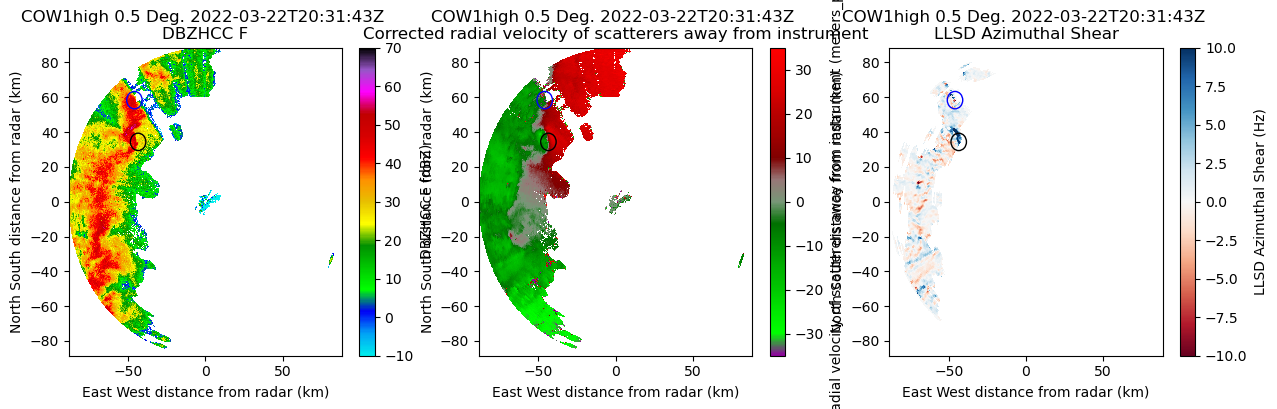

In [11]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, only_patches=True)

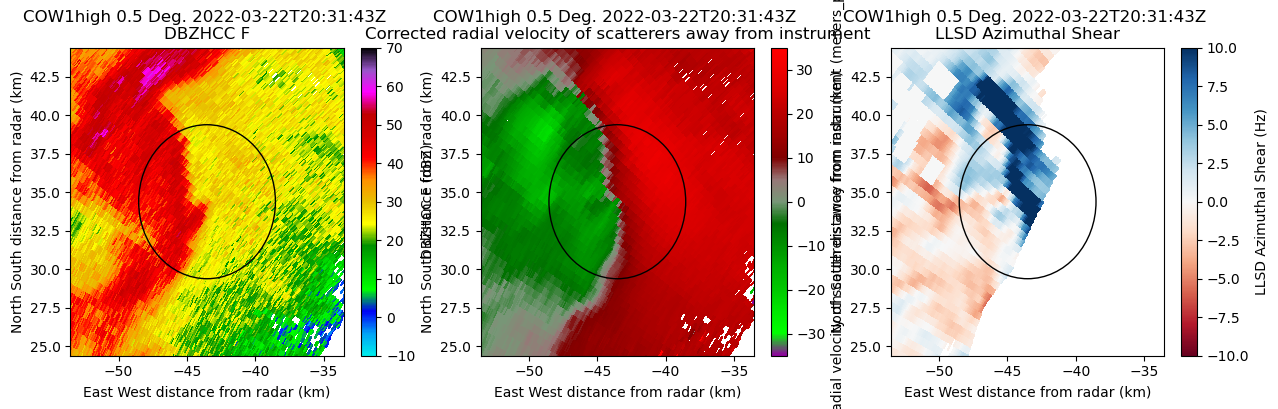

In [12]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, limits=True, plot_cyclonic=True)

In [13]:
radar = pyart.io.read(files[112])
refl_field = "DBZHCC_F"
vel_field = "VEL_F"
ncp_field = "NCP"
refl_thresh = 5 
ncp_thresh = None
rho_field = "RHOHV"
rho_thresh = 0.4
radar = filter_data(radar, refl_field,
                    refl_thresh=refl_thresh,
                    vel_field=vel_field,
                    ncp_field=ncp_field,
                    ncp_thresh=ncp_thresh,
                    rho_field=rho_field,
                    rho_thresh=rho_thresh,
                    dealias_method='region',
           )

/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pymeso/llsd.py:27: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_data    = scipy.ndimage.filters.median_filter(data, 3)


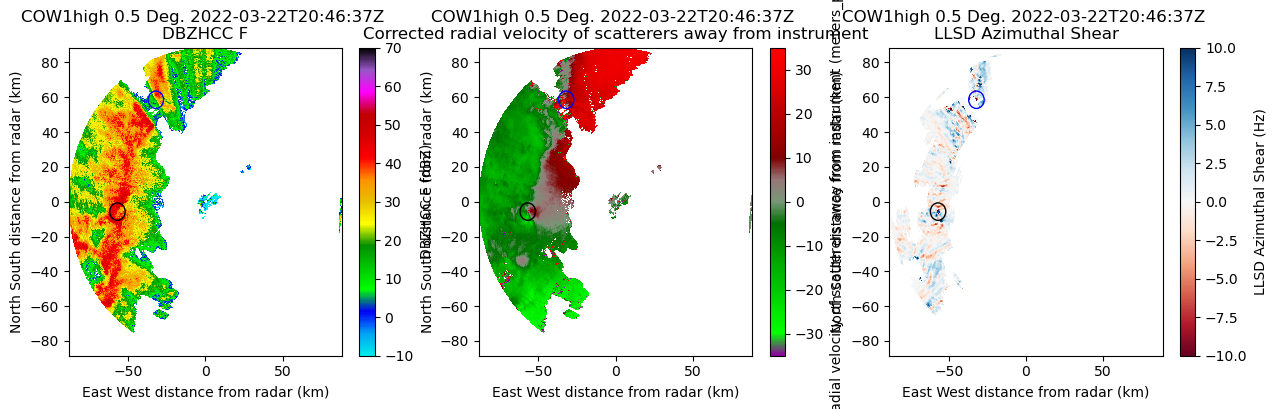

In [14]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, only_patches=True)

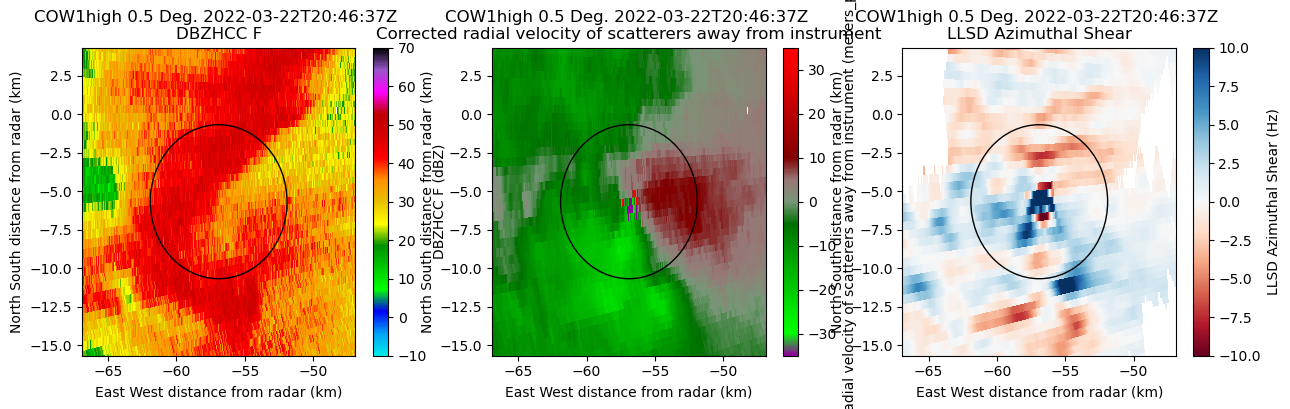

In [15]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, limits=True, plot_cyclonic=True)

In [16]:
radar = pyart.io.read(files[130])
refl_field = "DBZHCC_F"
vel_field = "VEL_F"
ncp_field = "NCP"
refl_thresh = 5 
ncp_thresh = None
rho_field = "RHOHV"
rho_thresh = 0.5
radar = filter_data(radar, refl_field,
                    refl_thresh=refl_thresh,
                    vel_field=vel_field,
                    ncp_field=ncp_field,
                    ncp_thresh=ncp_thresh,
                    rho_field=rho_field,
                    rho_thresh=rho_thresh,
                    dealias_method='region',
           )

/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pymeso/llsd.py:27: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_data    = scipy.ndimage.filters.median_filter(data, 3)


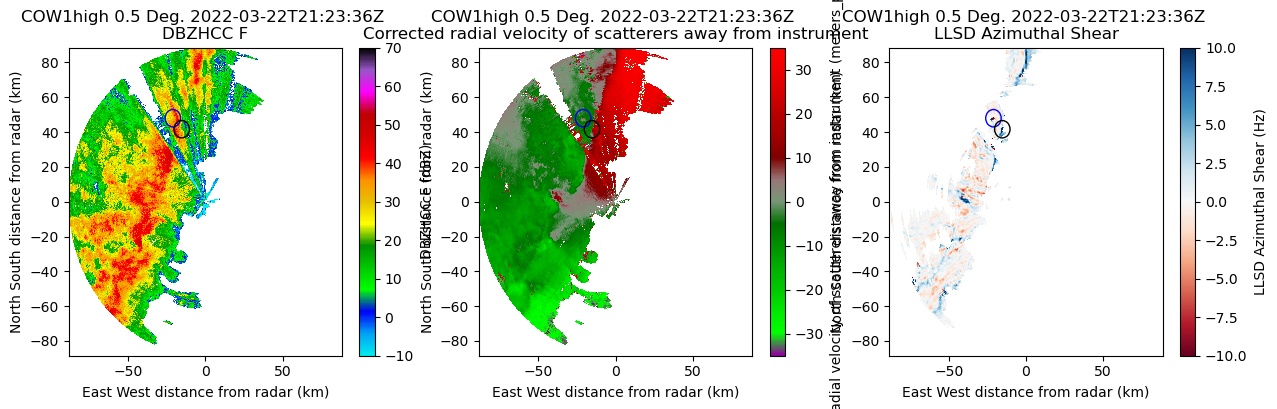

In [17]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, only_patches=True)

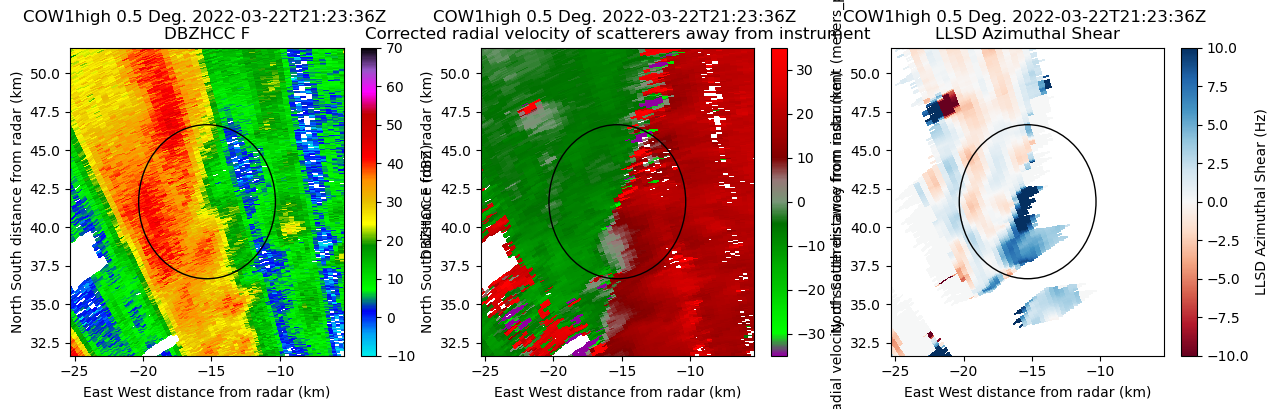

In [18]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, limits=True, plot_cyclonic=True)

In [19]:
radar = pyart.io.read(files[150])
refl_field = "DBZHCC_F"
vel_field = "VEL_F"
ncp_field = "NCP"
refl_thresh = 5 
ncp_thresh = None
rho_field = "RHOHV"
rho_thresh = 0.5
radar = filter_data(radar, refl_field,
                    refl_thresh=refl_thresh,
                    vel_field=vel_field,
                    ncp_field=ncp_field,
                    ncp_thresh=ncp_thresh,
                    rho_field=rho_field,
                    rho_thresh=rho_thresh,
                    dealias_method='region',
           )

/depot/dawson29/data/Projects/PERiLS/apps/perils/lib/python3.10/site-packages/pymeso/llsd.py:27: DeprecationWarning: Please use `median_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  smooth_data    = scipy.ndimage.filters.median_filter(data, 3)


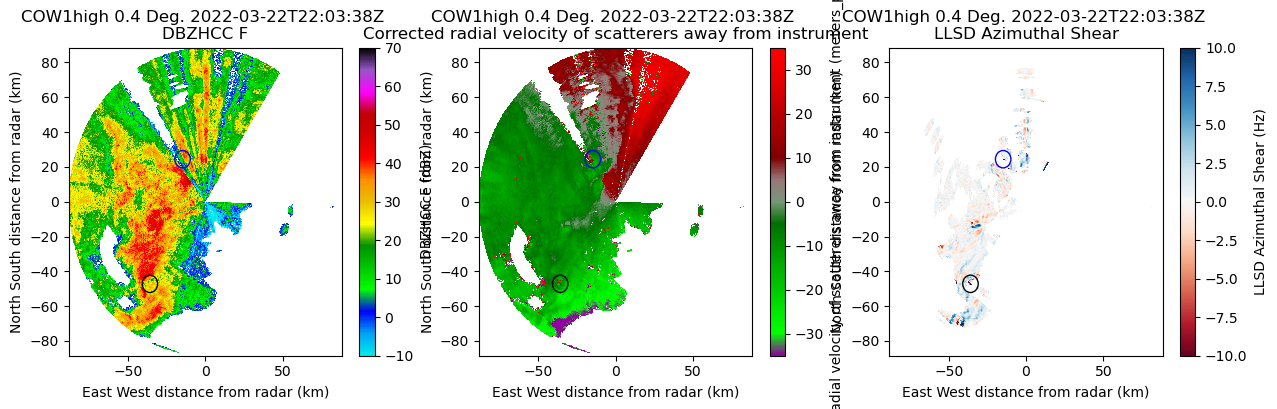

In [20]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, only_patches=True)

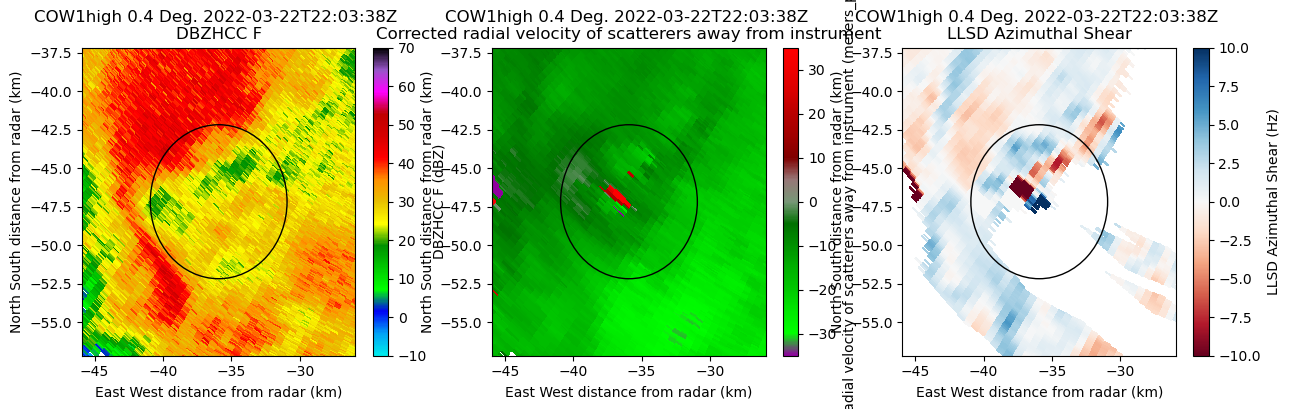

In [21]:
plot_radar(radar, refl_field=refl_field, vel_field=vel_field, sweep=0, limits=True, plot_cyclonic=True)

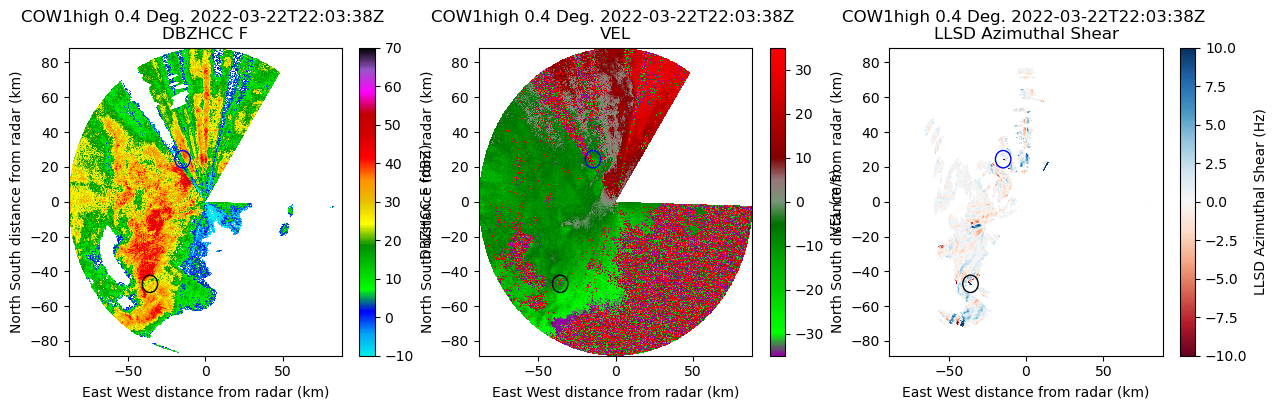

In [24]:
plot_radar(radar, refl_field=refl_field, vel_field='VEL', sweep=0, limits=False, 
           plot_cyclonic=True, only_patches=True)

In [25]:
files[150]

'/depot/dawson29/data/Projects/PERiLS/obsdata/2022/Illinois_Mobile_Radar/IOP1/COW1/cmerged/20220322/cfrad.20220322_220338.299_to_20220322_220506.977_COW1high_SUR.nc'